In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy.stats import skewnorm
from scipy.stats import norm

## Nifty 50 index data obtained from Bloomberg

In [2]:
df_nifty = pd.read_csv('nifty_50_idx.csv')

# Convert the Date field to datetime
df_nifty['Date'] = pd.to_datetime(df_nifty['Date'], dayfirst=True)

# Discretization of volatility states
states = [0, 1, 2]

# VOLATILITY_10D
df_nifty['VolState_10D'] = pd.qcut(
    df_nifty['VOLATILITY_10D'], 
    q = 3, 
    labels=states
)

# VOLATILITY_30D
df_nifty['VolState_30D'] = pd.qcut(
    df_nifty['VOLATILITY_30D'], 
    q = 3, 
    labels=states
)

# VOLATILITY_60D
df_nifty['VolState_60D'] = pd.qcut(
    df_nifty['VOLATILITY_60D'], 
    q = 3, 
    labels=states
)

# CALL_IMP_VOL_30D
df_nifty['VolState_CallImp'] = pd.qcut(
    df_nifty['CALL_IMP_VOL_30D'], 
    q = 3, 
    labels=states
)

df_nifty.head()

,Date,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,VOLATILITY_10D,VOLATILITY_30D,VOLATILITY_60D,CALL_IMP_VOL_30D,VolState_10D,VolState_30D,VolState_60D,VolState_CallImp
0,2024-01-01,21727.75,21834.35,21680.85,21741.90,11.09,10.26,10.71,14.22,1,0,0,1
1,2024-01-02,21751.35,21755.60,21555.65,21665.80,11.43,10.35,10.74,13.30,1,0,0,1
2,2024-01-03,21661.10,21677.00,21500.35,21517.35,8.55,10.78,10.72,13.18,0,0,0,1
3,2024-01-04,21605.80,21685.65,21564.55,21658.60,8.77,10.82,10.66,13.07,0,0,0,1
4,2024-01-05,21705.75,21749.60,21629.20,21710.80,8.66,10.77,10.62,12.03,0,0,0,0


### Plots of volatility with discretized regimes

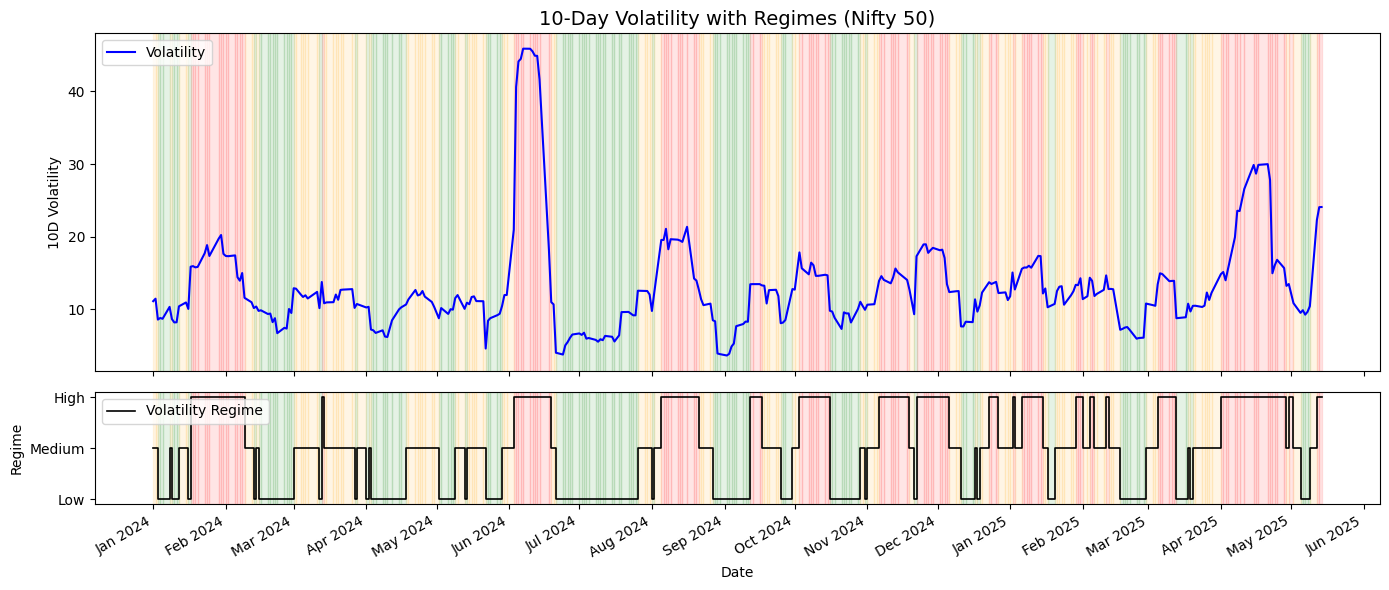

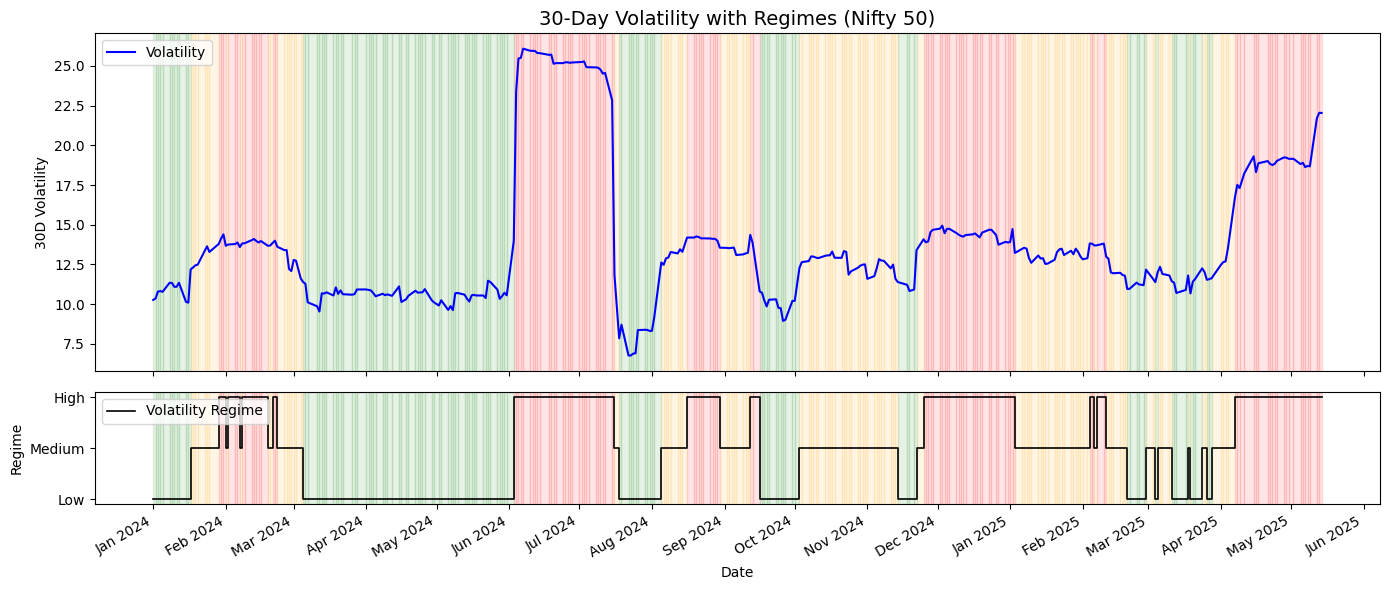

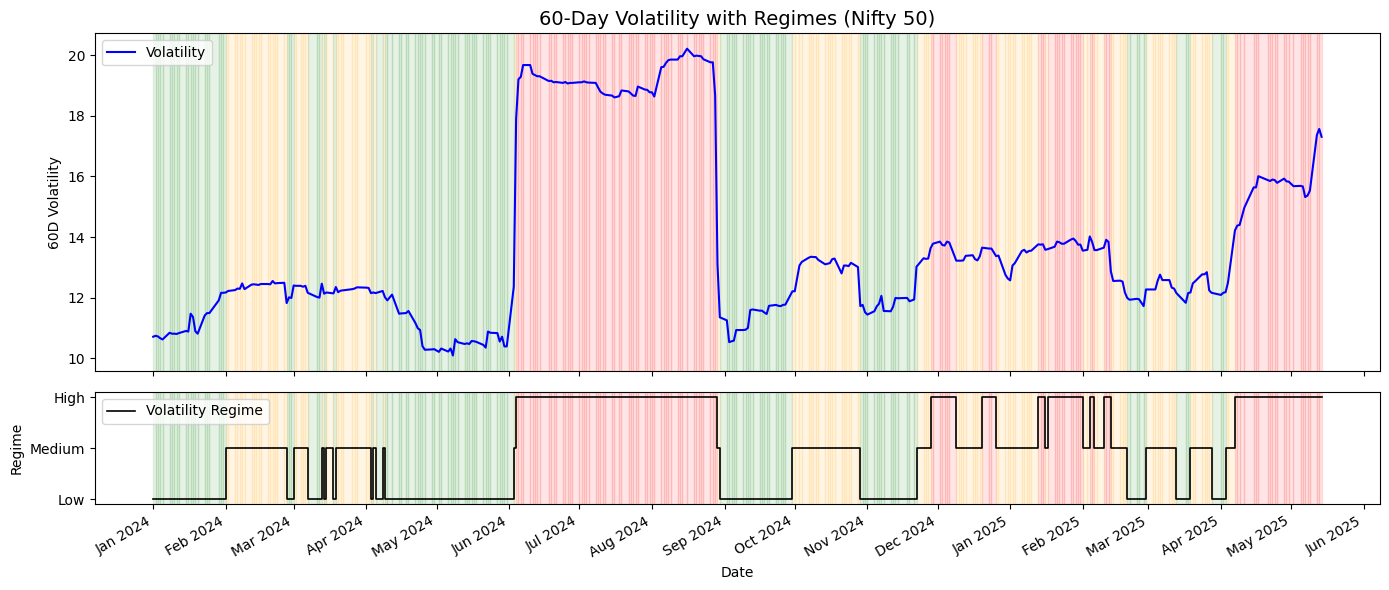

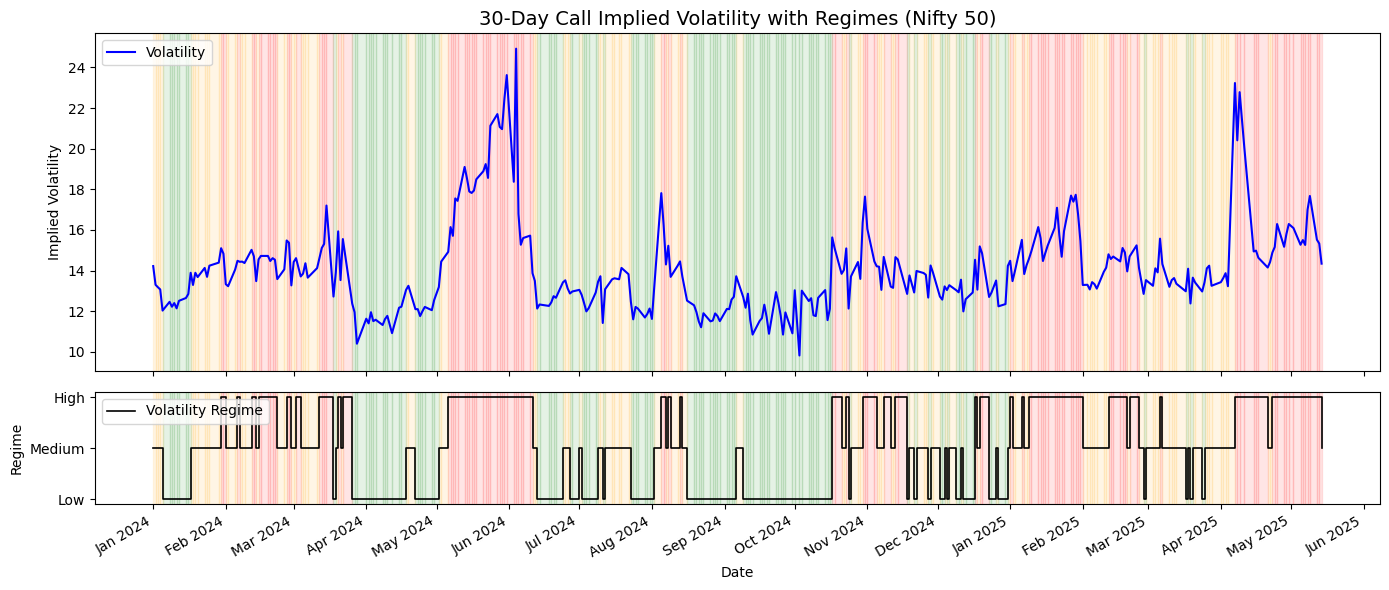

In [3]:
def plot_volatility_regimes(dates, volatility, vol_state, title, ylabel):
    # Color mapping
    state_colors = {0: 'green', 1: 'orange', 2: 'red'}
    # state_labels = {0: 'Low', 1: 'Medium', 2: 'High'}

    # Create a figure with two rows
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 6), sharex=True, height_ratios=[3, 1])

    # ----- Top plot: 10D Volatility Line -----
    ax1.plot(dates, volatility, label='Volatility', color='blue', linewidth=1.5)

    # Axis formatting
    ax1.set_title(title, fontsize=14)
    ax1.set_ylabel(ylabel)
    ax1.legend(loc='upper left')

    # ----- Bottom plot: VolState Step Plot -----
    ax2.step(dates, vol_state, where='post', color='black', linewidth=1.2, label='Volatility Regime')

    # Y-axis: show labels like "Low", "Medium", "High"
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Low', 'Medium', 'High'])
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Regime')
    ax2.legend(loc='upper left')
    
    # Background shading by regime
    for i in range(len(df) - 1):
        start_date = df.iloc[i]['Date']
        end_date = df.iloc[i + 1]['Date']
        state = vol_state.iloc[i]
        ax1.axvspan(start_date, end_date, color=state_colors[state], alpha=0.1)
        ax2.axvspan(start_date, end_date, color=state_colors[state], alpha=0.1)

    # X-axis formatting
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()
    
df = df_nifty

plot_volatility_regimes(df['Date'], df['VOLATILITY_10D'], df['VolState_10D'],
                        '10-Day Volatility with Regimes (Nifty 50)', '10D Volatility')

plot_volatility_regimes(df['Date'], df['VOLATILITY_30D'], df['VolState_30D'],
                        '30-Day Volatility with Regimes (Nifty 50)', '30D Volatility')

plot_volatility_regimes(df['Date'], df['VOLATILITY_60D'], df['VolState_60D'],
                        '60-Day Volatility with Regimes (Nifty 50)', '60D Volatility')

plot_volatility_regimes(df['Date'], df['CALL_IMP_VOL_30D'], df['VolState_CallImp'],
                        '30-Day Call Implied Volatility with Regimes (Nifty 50)', 'Implied Volatility')

### Functions for getting holding times, transitions and Q Matrix

In [4]:
# Function to get the holding times and transitions
def getHoldingTimesAndTransitions(vol_state, states):
    n_states = len(states)
    transitions = np.zeros((n_states, n_states))
    holding_times = np.zeros(n_states)

    for i in range(1, len(vol_state)):
        s_prev = vol_state.iloc[i-1]
        s_curr = vol_state.iloc[i]
        # delta_t = (df.iloc[i]['Date'] - df.iloc[i-1]['Date']).days # 1 day is the delta

        holding_times[s_prev] += 1
        if s_prev != s_curr:
            transitions[s_prev, s_curr] += 1
    
    return (holding_times, transitions)

# Compute the Q Matrix
def computeQMatrix(states, holding_times, transitions):
    n_states = len(states)
    Q = np.zeros((n_states, n_states))

    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                # print(i, j, transitions[i, j], holding_times[i], transitions[i, j]/holding_times[i])
                Q[i, j] = transitions[i, j] / holding_times[i]
        Q[i, i] = -np.sum(Q[i, :])
    
    return Q


holding_times, transitions = getHoldingTimesAndTransitions(df_nifty['VolState_10D'], states)

q_matrix = computeQMatrix(states, holding_times, transitions)
q_matrix

array([[-0.22807018,  0.19298246,  0.03508772],
       [ 0.21428571, -0.33928571,  0.125     ],
       [ 0.01785714,  0.13392857, -0.15178571]])

In [5]:
# Q Matrix for 10D Volatility
holding_times, transitions = getHoldingTimesAndTransitions(df_nifty['VolState_10D'], states)

q_matrix_10D = computeQMatrix(states, holding_times, transitions)
print("Q Matrix for 10D Volatility:")
print(q_matrix_10D)

# Q Matrix for 30D Volatility
holding_times, transitions = getHoldingTimesAndTransitions(df_nifty['VolState_30D'], states)

q_matrix_30D = computeQMatrix(states, holding_times, transitions)
print("\nQ Matrix for 30D Volatility:")
print(q_matrix_30D)

# Q Matrix for 60D Volatility
holding_times, transitions = getHoldingTimesAndTransitions(df_nifty['VolState_60D'], states)

q_matrix_60D = computeQMatrix(states, holding_times, transitions)
print("\nQ Matrix for 60D Volatility:")
print(q_matrix_60D)

# Q Matrix for 30D Call Imp Volatility
holding_times, transitions = getHoldingTimesAndTransitions(df_nifty['VolState_CallImp'], states)

q_matrix_30D_imp = computeQMatrix(states, holding_times, transitions)
print("\nQ Matrix for 30D Call Implied Volatility:")
print(q_matrix_30D_imp)

Q Matrix for 10D Volatility:
[[-0.22807018  0.19298246  0.03508772]
 [ 0.21428571 -0.33928571  0.125     ]
 [ 0.01785714  0.13392857 -0.15178571]]

Q Matrix for 30D Volatility:
[[-0.08849558  0.07964602  0.00884956]
 [ 0.07079646 -0.15929204  0.08849558]
 [ 0.00892857  0.08035714 -0.08928571]]

Q Matrix for 60D Volatility:
[[-0.11206897  0.11206897  0.        ]
 [ 0.10810811 -0.18018018  0.07207207]
 [ 0.          0.06306306 -0.06306306]]

Q Matrix for 30D Call Implied Volatility:
[[-0.21929825  0.20175439  0.01754386]
 [ 0.17857143 -0.41071429  0.23214286]
 [ 0.04464286  0.20535714 -0.25      ]]


### Simulating the chain

In [ ]:
def simulate_ctmc(Q, states, start_state, time_horizon, nTrials=1):
    current_state = states.index(start_state)
    time = 0
    history = [(time, states[current_state])]

    while time < time_horizon:
        rate = -Q[current_state, current_state]
        time += np.random.exponential(1/rate)

        probs = (Q[current_state]/rate)
        probs[current_state] = 0 # No self-transition

        next_state = np.random.choice(range(len(states)), p=probs)

        current_state = next_state
        history.append((float(np.round(time,2)), states[current_state]))
    
    return history

[(0, 'Medium'), (0.97, 'High'), (6.32, 'Medium'), (7.36, 'High'), (11.49, 'Medium'), (13.16, 'Low'), (13.66, 'Medium'), (18.58, 'High'), (26.1, 'Medium')]


([<matplotlib.axis.YTick at 0x11c4287d0>,
 [Text(0, 0, 'Low'), Text(0, 1, 'Medium'), Text(0, 2, 'High')])

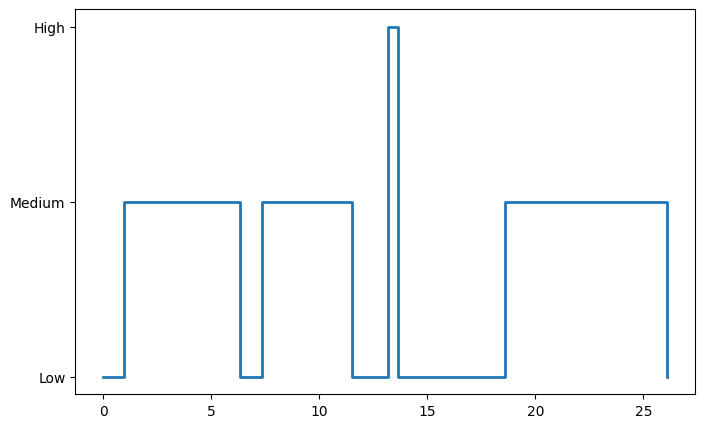

In [7]:
states = ["Low", "Medium", "High"]
result = simulate_ctmc(q_matrix_30D_imp, states, start_state="Medium", time_horizon=20)
print(result)

times = [result[i][0] for i in range(len(result))]
states = [result[i][1] for i in range(len(result))]

state_mapping = {
    "Low": 0,
    "Medium": 1,
    "High": 2
}

numeric_states = {state_mapping[state] for state in states}

plt.figure(figsize=(8, 5))
plt.step(times, states, where="post", linewidth=2)
plt.yticks([0, 1, 2], ["Low", "Medium", "High"])

## Stock Price SDE with geometric brownian motion (GBM)
$dS_t = \mu S_t dt + \sigma_{\eta_t} S_t\ dW_t\ ,\ \ \ \text{where } \sigma_{\eta_t} \in \{\sigma_1, \sigma_2\}$

$\text{for } 0 \leq t \leq s_1,\ \ \sigma_{\eta_t} = \sigma_1$

$S_t = S_0 \exp\left\{ \left( \mu - \dfrac{\sigma_1^2}{2} \right) t \ + \sigma_1\sqrt{t}\ Z_1\right\},\ \ \text{where  } Z_1 \sim \mathcal{N}(0, 1)$

$\implies \log\left( \dfrac{S_{t}}{S_{0}} \right) = \left( \mu - \dfrac{\sigma_1^2}{2} \right)t + \sigma_1\sqrt{t}\ Z_1$

Below is a more general form of the equation
$\log\left( \dfrac{S_{(n+1)h}}{S_{nh}} \right) \sim \mathcal{N}\left( \left( \mu - \dfrac{\sigma^2}{2} \right)h ,\ \ \sigma^2h\right)\\[15px]$

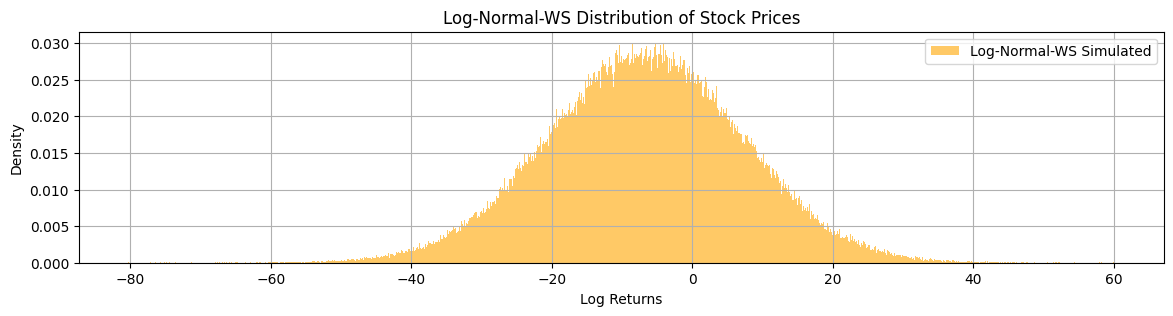

In [9]:
# Monte Carlo with switching for implied volatility
imp_vol_30_sigma = [
    df_nifty.loc[df_nifty['VolState_CallImp'] == 0, ['CALL_IMP_VOL_30D']].mean().values[0],
    df_nifty.loc[df_nifty['VolState_CallImp'] == 1, ['CALL_IMP_VOL_30D']].mean().values[0],
    df_nifty.loc[df_nifty['VolState_CallImp'] == 2, ['CALL_IMP_VOL_30D']].mean().values[0]
]

logNormalValuesWS = list()
nTrials = 200000
sigma = imp_vol_30_sigma
mu = 0.25 # Assuming a constant drift
t = 1
Z_t = np.random.normal(0, 1, size=nTrials)
for i in range(nTrials):
    markov_state = simulate_ctmc(q_matrix_30D_imp, ["Low", "Medium", "High"], start_state="Medium", time_horizon=3)
    current_state = None
    for j in range(len(markov_state)):
        if markov_state[j][0] > 1:
            # print(markov_state[i-1: i+1])
            current_state = markov_state[j-1][1]
            break

    volatility_state = state_mapping[current_state]
    logNormal = (mu - 0.5 * sigma[volatility_state]) * t + sigma[volatility_state] * np.sqrt(t) * Z_t[i]
    logNormalValuesWS.append(logNormal)
    
    # if i < 100:
    #     print(f"Iteration {i}: State: {current_state}, Log-Normal Value: {logNormal}")

plt.figure(figsize=(14, 3))
plt.hist(logNormalValuesWS, bins=1000, density=True, alpha=0.6, color='orange', label='Log-Normal-WS Simulated')

# Add normal distribution line
mean = np.mean(logNormalValuesWS)
std = np.std(logNormalValuesWS)

plt.title('Log-Normal-WS Distribution of Stock Prices')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()


In [11]:
erv = np.random.exponential(1/0.3, size=(200000,))

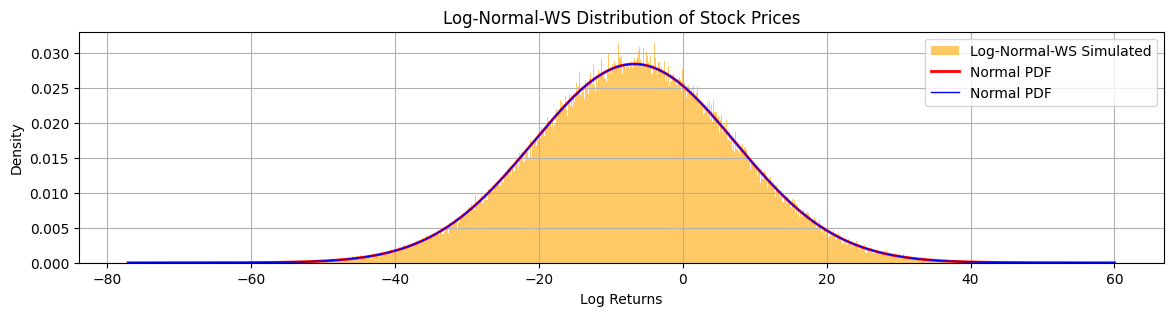

In [35]:
plt.figure(figsize=(14, 3))
plt.hist(logNormalValuesWS, bins=1000, density=True, alpha=0.6, color='orange', label='Log-Normal-WS Simulated')

# Add measured normal distribution line
mean = np.mean(logNormalValuesWS)
std = np.std(logNormalValuesWS)
x = np.linspace(min(logNormalValuesWS), max(logNormalValuesWS), 1000)
plt.plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label='Normal PDF')

# Add calculated normal distribution line
calculated_mean = mu - imp_vol_30_sigma[0]**2 / 2
calculated_std = np.sqrt(imp_vol_30_sigma[0]**2)
plt.plot(x, norm.pdf(x, mean, std), 'b-', lw=1, label='Normal PDF')

plt.title('Log-Normal-WS Distribution of Stock Prices')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

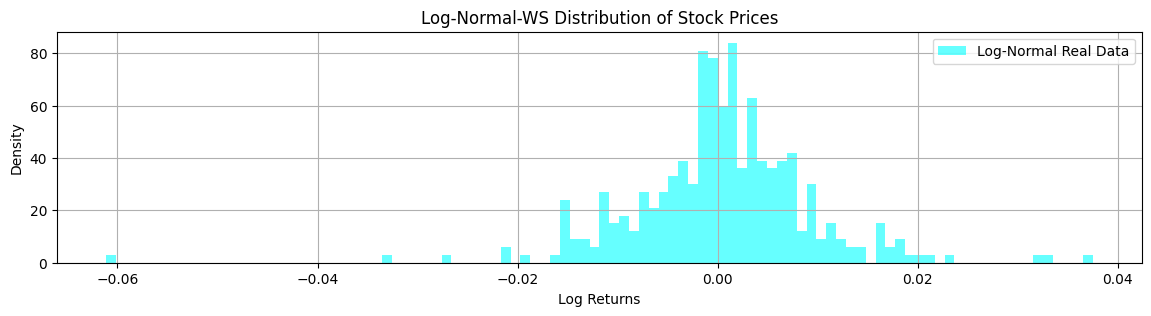

In [57]:
real_data_lognormal_values = np.log(df_nifty['PX_LAST'].iloc[1:].values/df_nifty['PX_LAST'].iloc[0:-1].values)

plt.figure(figsize=(14, 3))
plt.hist(real_data_lognormal_values, bins=100, density=True, alpha=0.6, color='cyan', label='Log-Normal Real Data')
plt.title('Log-Normal-WS Distribution of Stock Prices')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()